# <font face="gotham" color="Green">  Prototyping with Deep Learning  </font>

# Convolutional Neural Networks

## **Learning goals:** 

1. To start working with real image data.
2. To train and test a CNN model for a binary classification task with PyTorch.



## 1. Getting Data

In the previous tuorial we've used [MNIST](http://yann.lecun.com/exdb/mnist/) and [CIFAR-10 ](https://www.cs.toronto.edu/~kriz/cifar.html) datasets, which allowed us to skip preprocessing. 

- Today we will work with [Cats vs Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) dataset. click [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip) to download. The Cats Vs Dogs dataset contains two class of images Cats and Dogs. 

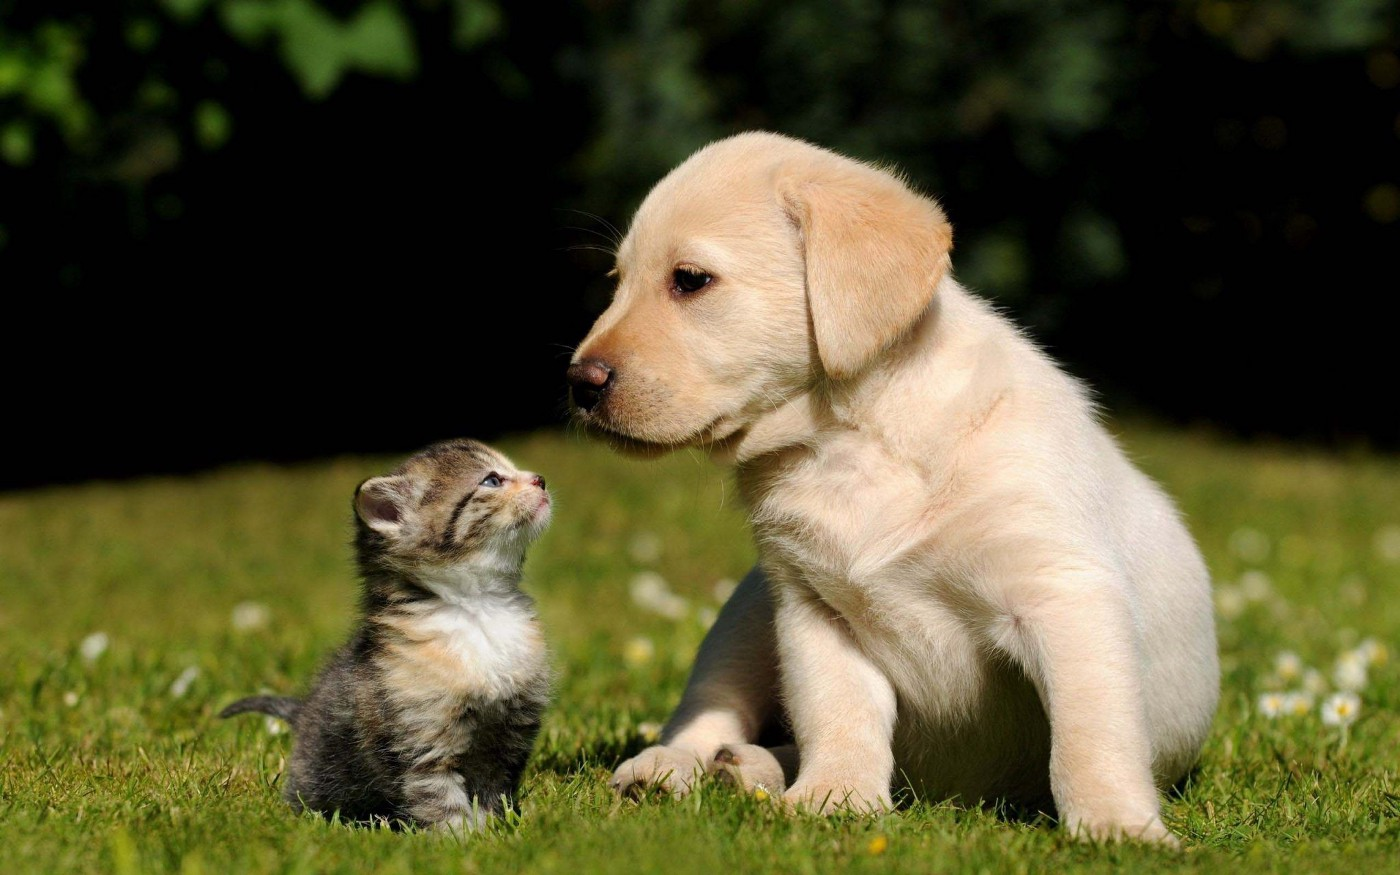

## 1.1 Preprocessing 

In [2]:
import os
import cv2
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

In [69]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|████████████████████████████████████| 12501/12501 [00:28<00:00, 439.76it/s]


PetImages/Dog


100%|████████████████████████████████████| 12501/12501 [00:29<00:00, 421.01it/s]
/Users/bereketaberayilma/ml_life/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


## 1.2 Loading data

Now we have a `training_data.npy` file to use this data we can just load it by doing: 

In [2]:
training_data = np.load("training_data.npy", allow_pickle=True) # allow_pickle = True for safer handling of untrusted sources
print(len(training_data))

24946


In [3]:
print(training_data[10])

[array([[ 81,  76,  77, ...,  87,  82,  79],
       [ 75,  76,  77, ...,  93,  91,  84],
       [ 74,  75,  76, ...,  95,  93,  91],
       ...,
       [ 70,  48, 163, ..., 213, 218, 215],
       [ 69, 150, 208, ..., 221, 224, 222],
       [180, 194, 194, ..., 230, 228, 226]], dtype=uint8)
 array([1., 0.])]


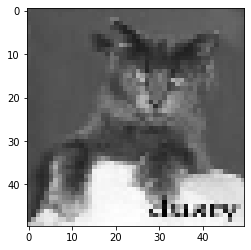

In [4]:
import matplotlib.pyplot as plt
plt.imshow(training_data[10][0], cmap = 'gray')
plt.show()

In [5]:
np.eye(2) # onehot encoding

array([[1., 0.],
       [0., 1.]])

#### Last Preprocessing 
- convert this to tensor
- Split your training and testing data

In [6]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
#Normalize X
X/255.0

y = torch.Tensor([i[1] for i in training_data])


In [7]:
# Slice data for train and test
slice_percentage = 0.1
slice_size = int(len(X)*slice_percentage)

train_X = X[:-slice_size]
train_y = y[:-slice_size]


test_X = X[-slice_size:]
test_y = y[-slice_size:]


In [8]:
print(f'size of training set = {len(train_X)}')

print(f'size of testing set = {len(test_X)}')

size of training set = 22452
size of testing set = 2494


## 2. Define a Convolutional Neural Network

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        
        #Method to calculate input dims to fc1 automatically
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 classes (dog vs cat).
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return F.softmax(x, dim=1)
    
    

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


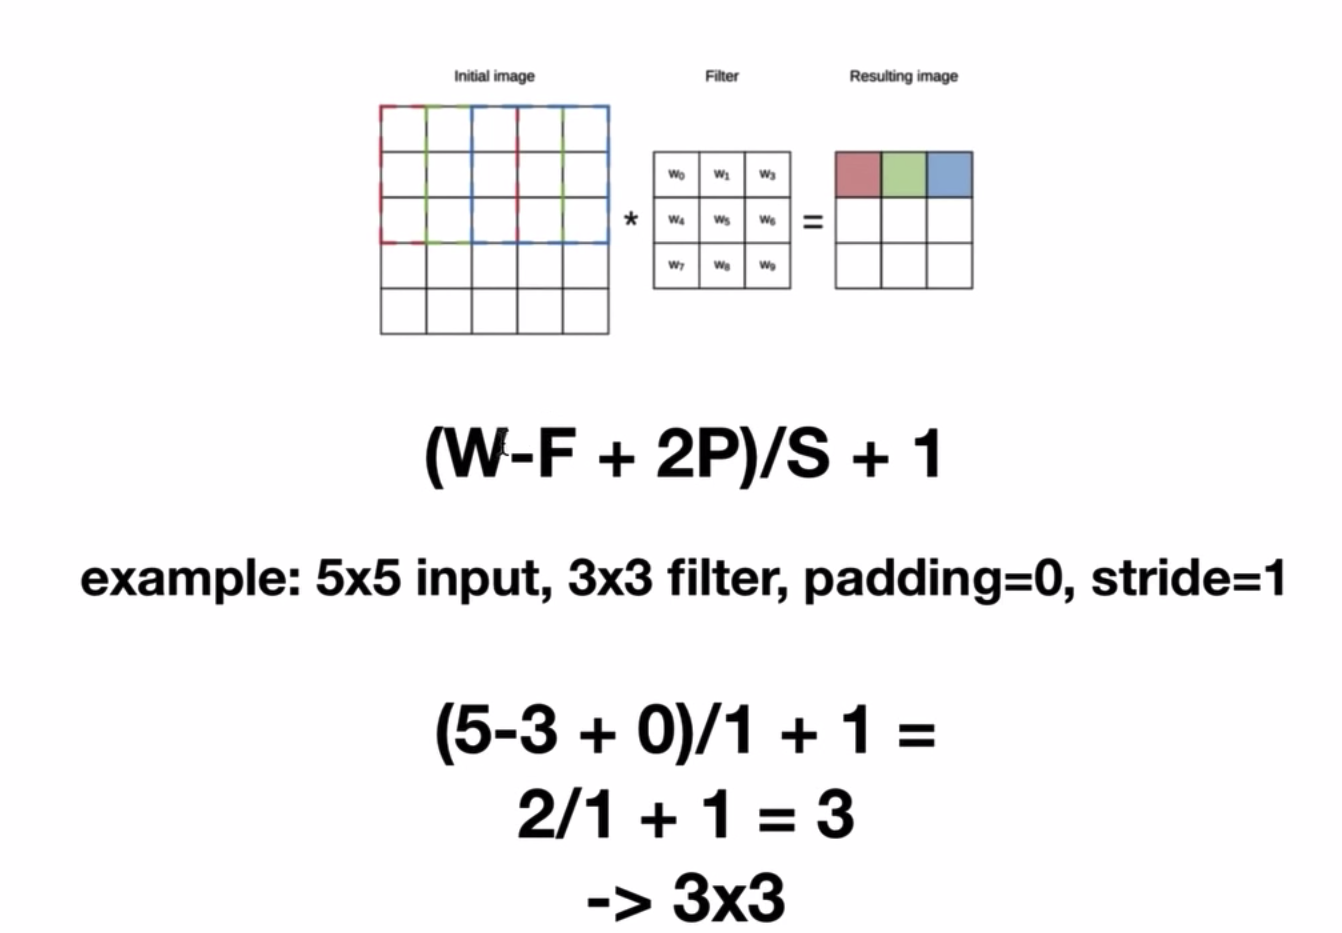

In [3]:
Image('dims.png')

## 3.  Define a Loss function and optimizer

In [88]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss('dims.png')

## 4. Train the network 

In [107]:
BATCH_SIZE = 10
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. 
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    #print(f"Epoch: {epoch}. Loss: {loss}")
print('Finished Training')

100%|███████████████████████████████████████| 2246/2246 [02:17<00:00, 16.33it/s]

Finished Training


## 5. Test the network on the test data

In [108]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████████████████████████████████| 2494/2494 [00:07<00:00, 331.62it/s]

Accuracy:  0.506


## 6. Save the model

In [109]:
PATH = './catsVsdogs.pth'
torch.save(net.state_dict(), PATH)